# Explicit feature map approximation for RBF kernels

Automatically created module for IPython interactive environment


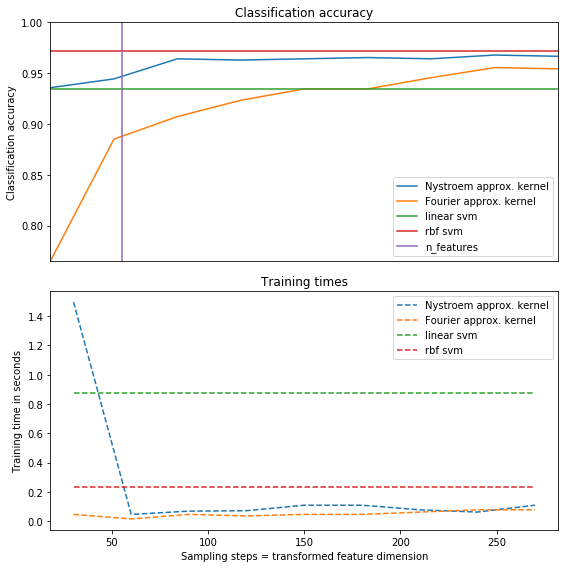

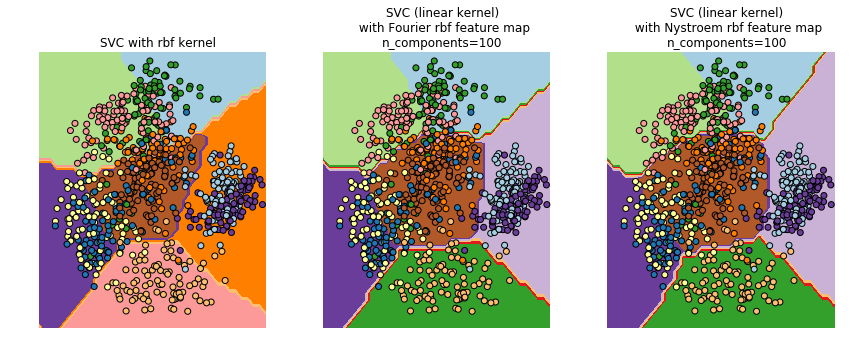

In [1]:
print(__doc__)

# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA

# The digits dataset
digits = datasets.load_digits(n_class=9)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.data)
data = digits.data / 16.
data -= data.mean(axis=0)

# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])
# data_test = scaler.transform(data_test)

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
plt.figure(figsize=(8, 8))
accuracy = plt.subplot(211)
# second y axis for timeings
timescale = plt.subplot(212)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

plt.tight_layout()
plt.figure(figsize=(12, 5))

# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm,
                         fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=targets_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [ ]:


\\# print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel)
}

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        # 这个是规定这个要画的子图的位置的
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

# SVM Exercise

A tutorial exercise for using different SVM kernels

The kernels included are linear,rbf and poly

Automatically created module for IPython interactive environment


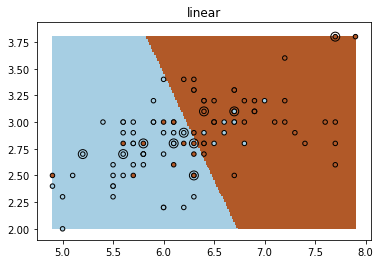

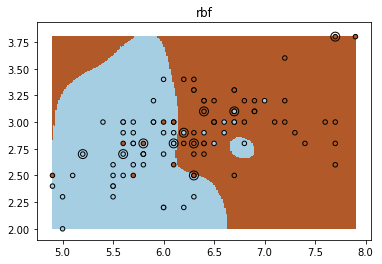

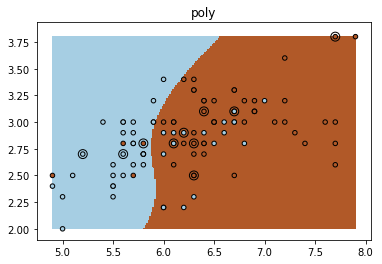

In [13]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y!=0,:2]
y = y[y!=0]
n_samples = len(X)

np.random.seed(0)
order = np.random.permutation(n_samples)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9*n_samples)]
y_train = y[:int(.9*n_samples)]
X_test = X[int(.9*n_samples):]
y_test = y[int(.9*n_samples):]

#fit the model
for fig_num,kernel in enumerate(('linear','rbf','poly')):
    clf = svm.SVC(kernel = kernel,gamma=10)
    clf.fit(X_train,y_train)
    
    plt.figure(fig_num)
    plt.clf()
    plt.scatter(X[:,0],X[:,1],c=y,zorder=10,cmap=plt.cm.Paired,edgecolor='k',s=20)
    
    #Circle out the test data
    plt.scatter(X_test[:,0],X_test[:,1],s=80,facecolors='none',zorder=10,edgecolor='k')
    
    plt.axis('tight')
    x_min = X[:,0].min()
    x_max = X[:,0].max()
    y_min = X[:,1].min()
    y_max = X[:,1].max()
    
    XX,YY = np.mgrid[x_min:x_max:200j,y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(),YY.ravel()])
    
    # Put thr result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX,YY,Z>0,cmap=plt.cm.Paired)
#     plt.contour(XX,YY,Z,colors=['k','k','k'],linestyles=['--','-','--'],levels=[-.5,0,.5])
    plt.title(kernel)
plt.show()